In [1]:
%matplotlib widget

# Thermal simulation of heat exchanger for steady water heating

from dataclasses import dataclass
import numpy as np

from math import pi

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation


import time
from matplotlib.ticker import FormatStrFormatter

In [2]:
class water:
    density: float = 1000.0 # kg/m^3
    heat_capacity: float = 4180.0 # J/kg/K

class steel:
    density: float = 7800.0 # kg/m^3
    heat_capacity: float = 450.0 # J/kg/K

class heat_exchanger:
    product_surface: float = 10.0 # m^2
    air_surface: float = 11.0 # m^2
    metal_weight: float = 230.0 # kg

    water_pipe_length: float = 1.0 # m
    water_pipe_radius: float = 0.005 # m

    water_metal_heat_transfer_coefficient: float = 0.0 # W/m^2/K
    metal_air_heat_transfer_coefficient: float = 0.0 # W/m^2/K
    metal_product_heat_transfer_coefficient: float = 0.0 # W/m^2/K

class discretization:
    nodes: int = 40
    time_step: float = 0.005 # s/step

class product:
    heat_capacity: float = 3890.0 # J/kg/K
    mass: float = 100.0 # kg

class water_node:
    surface_metal: float = pi * heat_exchanger.water_pipe_radius * 2 * heat_exchanger.water_pipe_length / discretization.nodes # m^2
    volume: float = pi * heat_exchanger.water_pipe_radius ** 2 * heat_exchanger.water_pipe_length / discretization.nodes # m^3
    mass: float = water.density * pi * heat_exchanger.water_pipe_radius**2 * heat_exchanger.water_pipe_length / discretization.nodes

class metal_node:
    surface_product: float = heat_exchanger.product_surface / discretization.nodes
    surface_air: float = heat_exchanger.air_surface / discretization.nodes


In [8]:

# Configurable variables

input_water_temperature = 70 # degC
air_temperature = 25 # degC
starting_water_temperature = 25.0 # degC
starting_metal_temperature = 25.0 # degC
starting_product_temperature = 25.0 # degC
water_flow_rate = 0.1 # kg/s
simulation_time = 300 # s


In [4]:
# Conduction heat rate formula
def heat_rate_conduction_boundary(origin_temperature: float, destiny_temperature: float, transfer_surface: float, transfer_coefficient: float) -> float:
    return transfer_surface * transfer_coefficient * (origin_temperature - destiny_temperature)

# Temperature change formula
def next_temperature(previous_temperature: float, heat_rate: float, heat_capacity: float, mass: float) -> float:
    return previous_temperature + heat_rate / (heat_capacity * mass)


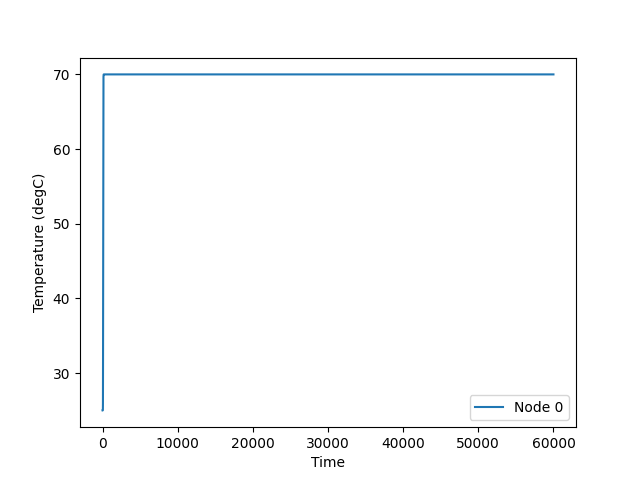

In [9]:

figure = plt.figure()
axes = figure.subplots(1,1)

nodes_water_temperature  = np.full(discretization.nodes, starting_water_temperature, dtype=float) # degC

nodes_water_to_water_heat = np.zeros(discretization.nodes, dtype=float)

node_data = np.zeros(int(simulation_time/discretization.time_step), dtype=float) # degC

for step in range(0, int(simulation_time/discretization.time_step)):
    
    nodes_water_to_water_heat[0] = water_flow_rate * water.heat_capacity * (input_water_temperature - nodes_water_temperature[0]) * discretization.time_step

    for node in range(1, discretization.nodes):
        nodes_water_to_water_heat[node] = water_flow_rate * water.heat_capacity * (nodes_water_temperature[node-1] - nodes_water_temperature[node]) * discretization.time_step

    for node in range(0, discretization.nodes):
        nodes_water_temperature[node] = next_temperature(nodes_water_temperature[node], nodes_water_to_water_heat[node], water.heat_capacity, water_node.mass)

    node_data[step] = nodes_water_temperature[20]

temperature_line, = axes.plot(node_data, label="Node 0")

axes.set_xlabel("Time")
axes.set_ylabel("Temperature (degC)")
axes.legend()

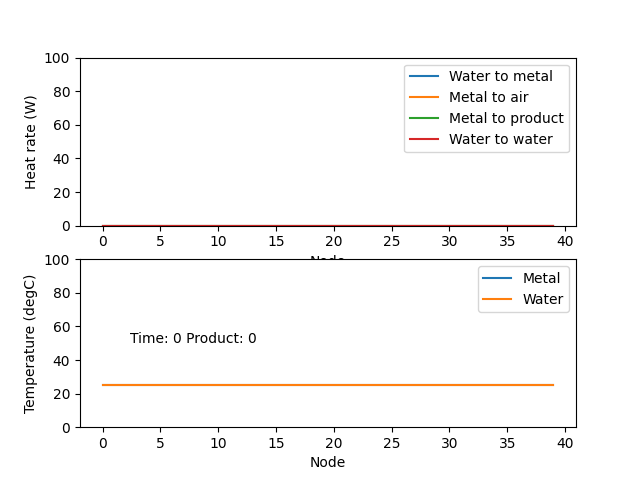

In [6]:
class Simulator01:
    def __init__(self):
        self.nodes_water_temperature  = np.full(discretization.nodes, starting_water_temperature, dtype=float) # degC
        self.nodes_metal_temperature  = np.full(discretization.nodes, starting_metal_temperature, dtype=float) # degC

        self.product_temperature = starting_product_temperature # degC

        nodes_water_to_metal_heat = np.zeros(discretization.nodes, dtype=np.float64) # W
        nodes_water_to_water_heat = np.zeros(discretization.nodes, dtype=np.float64) # W
        nodes_metal_to_air_heat = np.zeros(discretization.nodes, dtype=np.float64) # W
        nodes_metal_to_product_heat = np.zeros(discretization.nodes, dtype=np.float64) # W

    def Step(self):
    # Calculate heat rates

        nodes_water_to_water_heat[0] = water_flow_rate * water.heat_capacity * (input_water_temperature - nodes_water_temperature[0]) * discretization.time_step
        for i in range(0, discretization.nodes):
            self.nodes_water_to_metal_heat[i] = heat_rate_conduction_boundary(nodes_water_temperature[i], nodes_metal_temperature[i], water_node.surface_metal, heat_exchanger.water_metal_heat_transfer_coefficient)

        for i in range(1, discretization.nodes):
            self.nodes_water_to_water_heat[i] = water_flow_rate * water.heat_capacity * (nodes_water_temperature[i-1] - nodes_water_temperature[i]) * discretization.time_step

        for i in range(0, discretization.nodes):
            self.nodes_metal_to_air_heat[i] = heat_rate_conduction_boundary(nodes_metal_temperature[i], air_temperature, metal_node.surface_air, heat_exchanger.metal_air_heat_transfer_coefficient)

        for i in range(0, discretization.nodes):
            self.nodes_metal_to_product_heat[i] = heat_rate_conduction_boundary(nodes_metal_temperature[i], product_temperature, metal_node.surface_product, heat_exchanger.metal_product_heat_transfer_coefficient)

        # Calculate temperatures

        self.product_temperature = product_temperature + np.sum(self.nodes_metal_to_product_heat) * discretization.time_step / (product.heat_capacity * product.mass)

        for i in range(0, discretization.nodes):
            self.nodes_metal_temperature[i] = next_temperature(nodes_metal_temperature[i], nodes_water_to_metal_heat[i] - nodes_metal_to_air_heat[i] - nodes_metal_to_product_heat[i], steel.heat_capacity, heat_exchanger.metal_weight)

        self.nodes_water_temperature[0] = next_temperature(nodes_water_temperature[0], (- nodes_water_to_metal_heat[0] + nodes_water_to_water_heat[0]), water.heat_capacity, water.density * water_node.volume)
        
        for i in range(1, discretization.nodes):
            self.nodes_water_temperature[i] = next_temperature(nodes_water_temperature[i], (- nodes_water_to_metal_heat[i] + nodes_water_to_water_heat[i]), water.heat_capacity, water.density * water_node.volume)



figure = plt.figure()
axes = figure.subplots(1,1)

    nodes_water_temperature  = np.full(discretization.nodes, starting_water_temperature, dtype=float) # degC
    nodes_metal_temperature  = np.full(discretization.nodes, starting_metal_temperature, dtype=float) # degC
product_temperature = starting_product_temperature # degC

nodes_water_temperature  = np.full(discretization.nodes, starting_water_temperature, dtype=float) # degC

nodes_water_to_water_heat = np.zeros(discretization.nodes, dtype=float)

node_data = np.zeros(int(simulation_time/discretization.time_step), dtype=float) # degC

for step in range(0, int(simulation_time/discretization.time_step)):
    
    nodes_water_to_water_heat[0] = water_flow_rate * water.heat_capacity * (input_water_temperature - nodes_water_temperature[0]) * discretization.time_step

    for node in range(1, discretization.nodes):
        nodes_water_to_water_heat[node] = water_flow_rate * water.heat_capacity * (nodes_water_temperature[node-1] - nodes_water_temperature[node]) * discretization.time_step

    for node in range(0, discretization.nodes):
        nodes_water_temperature[node] = next_temperature(nodes_water_temperature[node], nodes_water_to_water_heat[node], water.heat_capacity, water_node.mass)

    node_data[step] = nodes_water_temperature[20]

temperature_line, = axes.plot(node_data, label="Node 0")

axes.set_xlabel("Time")
axes.set_ylabel("Temperature (degC)")
axes.legend()

In [ ]:

temperature_figure = plt.figure()
heat_axes, temperature_axes = temperature_figure.subplots(2,1)

heat_water_metal_line, = heat_axes.plot(np.zeros(discretization.nodes, dtype=np.float64), label="Water to metal")
heat_metal_air_line, = heat_axes.plot(np.zeros(discretization.nodes, dtype=np.float64), label="Metal to air")
heat_metal_product_line, = heat_axes.plot(np.zeros(discretization.nodes, dtype=np.float64), label="Metal to product")
heat_water_to_water, = heat_axes.plot(np.zeros(discretization.nodes, dtype=np.float64), label="Water to water")

metal_temperature_line, = temperature_axes.plot(np.full(discretization.nodes, starting_metal_temperature, dtype=np.float64), label="Metal")
water_temperature_line, = temperature_axes.plot(np.full(discretization.nodes, starting_water_temperature, dtype=np.float64), label="Water")

# Plotting

temperature_axes.set_xlabel("Node")
temperature_axes.set_ylabel("Temperature (degC)")
temperature_axes.set_ylim(0, 100)
temperature_axes.legend()

heat_axes.set_xlabel("Node")
heat_axes.set_ylabel("Heat rate (W)")
heat_axes.set_ylim(0, 100)
heat_axes.legend()

# heat_axes.set_xlabel("Node")
# heat_axes.set_ylabel("Heat rate (W)")

text = temperature_axes.text(0.1, 0.5, f'Time: {str(0)} Product: {0}', transform=temperature_axes.transAxes)

def start():
    return [metal_temperature_line, water_temperature_line]

def sim():
    # Process variables
    nodes_water_to_metal_heat = np.zeros(discretization.nodes, dtype=np.float64)
    nodes_water_to_water_heat = np.zeros(discretization.nodes, dtype=np.float64)
    nodes_metal_to_air_heat = np.zeros(discretization.nodes, dtype=np.float64)
    nodes_metal_to_product_heat = np.zeros(discretization.nodes, dtype=np.float64)

    nodes_water_temperature  = np.full(discretization.nodes, starting_water_temperature, dtype=float) # degC
    nodes_metal_temperature  = np.full(discretization.nodes, starting_metal_temperature, dtype=float) # degC


    product_temperature = starting_product_temperature # degC

    for step in range(0, int(simulation_time/discretization.time_step)):

        # Calculate heat rates

        nodes_water_to_water_heat[0] = water_flow_rate * water.heat_capacity * (input_water_temperature - nodes_water_temperature[0]) * discretization.time_step
        for i in range(0, discretization.nodes):
            nodes_water_to_metal_heat[i] = heat_rate_conduction_boundary(nodes_water_temperature[i], nodes_metal_temperature[i], water_node.surface_metal, heat_exchanger.water_metal_heat_transfer_coefficient)

        for i in range(1, discretization.nodes):
            nodes_water_to_water_heat[i] = water_flow_rate * water.heat_capacity * (nodes_water_temperature[i-1] - nodes_water_temperature[i]) * discretization.time_step

        for i in range(0, discretization.nodes):
            nodes_metal_to_air_heat[i] = heat_rate_conduction_boundary(nodes_metal_temperature[i], air_temperature, metal_node.surface_air, heat_exchanger.metal_air_heat_transfer_coefficient)

        for i in range(0, discretization.nodes):
            nodes_metal_to_product_heat[i] = heat_rate_conduction_boundary(nodes_metal_temperature[i], product_temperature, metal_node.surface_product, heat_exchanger.metal_product_heat_transfer_coefficient)

        # Calculate temperatures

        product_temperature = product_temperature + np.sum(nodes_metal_to_product_heat) * discretization.time_step / (product.heat_capacity * product.mass)

        for i in range(0, discretization.nodes):
            nodes_metal_temperature[i] = next_temperature(nodes_metal_temperature[i], nodes_water_to_metal_heat[i] - nodes_metal_to_air_heat[i] - nodes_metal_to_product_heat[i], steel.heat_capacity, heat_exchanger.metal_weight)

        nodes_water_temperature[0] = next_temperature(nodes_water_temperature[0], (- nodes_water_to_metal_heat[0] + nodes_water_to_water_heat[0]), water.heat_capacity, water.density * water_node.volume)
        
        for i in range(1, discretization.nodes):
            nodes_water_temperature[i] = next_temperature(nodes_water_temperature[i], (- nodes_water_to_metal_heat[i] + nodes_water_to_water_heat[i]), water.heat_capacity, water.density * water_node.volume)

        yield [nodes_water_temperature, nodes_metal_temperature, product_temperature, nodes_water_to_metal_heat, nodes_metal_to_air_heat, nodes_metal_to_product_heat, nodes_water_to_water_heat, step]


def animate(data):

    nodes_water_temperature, nodes_metal_temperature, product_temperature, nodes_water_to_metal_heat, nodes_metal_to_air_heat, nodes_metal_to_product_heat, nodes_water_to_water_heat, step = data

    heat_water_metal_line.set_ydata(nodes_water_to_metal_heat)
    heat_metal_air_line.set_ydata(nodes_metal_to_air_heat)
    heat_metal_product_line.set_ydata(nodes_metal_to_product_heat)
    heat_water_to_water.set_ydata(nodes_water_to_water_heat)

    metal_temperature_line.set_ydata(nodes_metal_temperature)
    water_temperature_line.set_ydata(nodes_water_temperature)

    text.set_text(f'Time: {(step):.2f} Product: {product_temperature} Metal: {nodes_metal_temperature[0]:.2f} Water: {nodes_water_temperature[0]:.2f}')

    return [metal_temperature_line, water_temperature_line]

animation = FuncAnimation(temperature_figure, animate, frames=sim, interval=5, save_count=1, init_func=start, repeat=False, blit=True)

plt.show()
